# Predicting the Lead via k-nn

## Misclassification benchmark results with 10 fold cross-validation
* 0.17871287128712868 with k=84, dropping the 0 values and using only 2 composite features
* 0.19824495892457056 with k=64, using only 2 composite features (without dropping the 0 values)
* 0.19844690351388078 with k=19, using Number of female actors, Number of male actors, Age Lead, Age Co-Lead
* 0.2004562220927975 with k=16, using 2 composite + Number of female actors, Number of male actors, Age Lead, Age Co-Lead
* 0.204319549602019 with k=9, using all features + 2 composite features
* 0.204319549602019 with k=9, using all features


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.model_selection as skl_ms
import sklearn.neighbors as skl_nb

In [52]:
# Load train dataset
url = 'data/train.csv'
data = pd.read_csv(url)

### About noise in the data

* Entries where 'Number words female' is 0, show invariably to be led by Female.
* Entries where 'Number words male' is 0, show invariably to be led by Male.

From the discussion thread, the teaching assistant says:

_"it is possible to use this information as a valuable feature for the model in this particular case"_

This hints in using it as a special rule for prediction. However, for the moment, while we tune the models, I would suggest dropping these values as they add noise

In [53]:
# Get names of indexes for which the number of words of female or male is 0
dropIndex = data[ (data['Number words female'] == 0) | (data['Number words male'] == 0) ].index

# Delete the rows from the dataset
data.drop(dropIndex , inplace=True)

### Add combined features to the dataset
`nV1`: Gender actor relation: 'Number of female actors'/('Number of female actors' + 'Number of male actors').

`nV2`: Age relation: 'Age Co-Lead' / 'Age Lead'.

In [54]:
# Add combined features
data['nV1'] = data['Number of female actors']/(data['Number of female actors']+data['Number of male actors'])
data['nV2'] = data['Age Co-Lead']/data['Age Lead']

### Checking the info

In [ ]:
data.head()

In [25]:
data.describe()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,nV1,nV2
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,2375.824284,11147.630800,4156.122409,2567.855874,7.818361,1999.842053,3.563672,4615.684107,109.979269,42.256765,35.972203,38.777887,35.390918,0.324534,0.989888
std,2150.615952,6822.072347,2988.035028,2511.340011,3.880194,10.425850,2.080196,3429.487030,151.832276,7.766994,8.934847,12.302472,12.038279,0.156467,0.462870
min,102.000000,1351.000000,318.000000,1.000000,1.000000,1939.000000,1.000000,113.000000,0.000000,19.000000,13.000000,11.000000,7.000000,0.052632,0.200000
25%,965.000000,6581.000000,2111.000000,869.000000,5.000000,1994.000000,2.000000,2188.000000,22.000000,37.285714,29.500000,30.000000,28.000000,0.200000,0.733333
50%,1730.000000,9351.000000,3398.000000,1850.000000,7.000000,2000.000000,3.000000,3882.000000,59.000000,42.500000,35.000000,38.000000,34.000000,0.304348,0.900000
75%,3073.000000,14205.000000,5292.000000,3436.000000,10.000000,2009.000000,5.000000,5930.000000,140.000000,47.260870,41.500000,46.000000,41.000000,0.428571,1.111111
max,17658.000000,67548.000000,28102.000000,25822.000000,29.000000,2015.000000,16.000000,31146.000000,1798.000000,71.000000,81.333333,81.000000,85.000000,0.900000,4.583333


### 10-fold cross-validation
Perform 10-fold cross-validation by first randomly permuting the data set, divide the data set into 10 equally sized parts and loop through them by taking one part as validation set and the rest as training set each time. Reviewing wich $k$ gives the best result

In [55]:
#X = data[['Number words female', 'Total words', 'Number of words lead', 'Difference in words lead and co-lead', \
#         'Number of male actors', 'Year', 'Number of female actors', 'Number words male', 'Gross', 'Mean Age Male', \
#         'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'nV1', 'nV2']]
#X = data[['nV1', 'nV2']]
#X = data[['Number of female actors', 'Number of male actors', 'Age Lead', 'Age Co-Lead']]
X = data[['nV1', 'nV2', 'Number of female actors', 'Number of male actors', 'Age Lead', 'Age Co-Lead']]
y = data['Lead']

X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size=0.3, random_state=1)

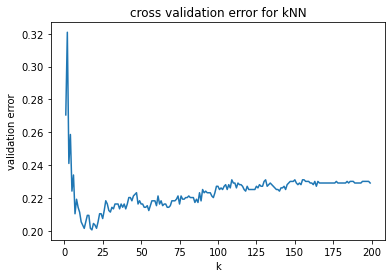

In [56]:
# Using Scikit learn KFold
n_fold = 10
k_range = 200

cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
K = np.arange(1,k_range)
misclassification = np.zeros(len(K))
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        misclassification[j] += np.mean(prediction != y_val)

misclassification /= n_fold

# Plotting the result (takes time, so run when there are relevant changes)
plt.plot(K, misclassification)
plt.title('cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('validation error')
plt.show()

In [57]:
misclassification[5:25]

array([0.23392545, 0.21028926, 0.21914191, 0.21425937, 0.21123083,
       0.20535818, 0.20337798, 0.20139779, 0.20531936, 0.20932829,
       0.20931858, 0.20143661, 0.20045622, 0.20440691, 0.2033974 ,
       0.20144632, 0.2053873 , 0.21031838, 0.21030868, 0.20737721])

In [58]:
min(misclassification[5:25])

0.2004562220927975

In [61]:
misclassification[17]

0.2004562220927975